In [5]:
import matplotlib.pyplot as plt
import pandas as pd

Using the epidemiology data from Orphanet (https://www.orphadata.com/data/xml/en_product9_prev.xml) I want to get a list of Orphenet IDs, their prevalance (there are different metrics for this and counting approaches) so I can use them as a comparison group in my link prediction tasks


In [6]:
# read in the xml file ../Resources/en_product9_prev.xml
import xml.etree.ElementTree as ET
tree = ET.parse('../Resources/en_product9_prev.xml')
root = tree.getroot()
print(root.tag)
root.keys()
dl = root.find('DisorderList')
print(dl.tag)
for disorder in dl:
    print(disorder.tag, disorder.attrib, disorder.text)
    

JDBOR
DisorderList
Disorder {'id': '17601'} 
      
Disorder {'id': '2'} 
      
Disorder {'id': '17603'} 
      
Disorder {'id': '3'} 
      
Disorder {'id': '17602'} 
      
Disorder {'id': '17605'} 
      
Disorder {'id': '5'} 
      
Disorder {'id': '17604'} 
      
Disorder {'id': '6'} 
      
Disorder {'id': '7'} 
      
Disorder {'id': '8'} 
      
Disorder {'id': '17608'} 
      
Disorder {'id': '17611'} 
      
Disorder {'id': '17610'} 
      
Disorder {'id': '11'} 
      
Disorder {'id': '17613'} 
      
Disorder {'id': '12'} 
      
Disorder {'id': '17612'} 
      
Disorder {'id': '13'} 
      
Disorder {'id': '17615'} 
      
Disorder {'id': '14'} 
      
Disorder {'id': '17614'} 
      
Disorder {'id': '15'} 
      
Disorder {'id': '17616'} 
      
Disorder {'id': '17'} 
      
Disorder {'id': '17617'} 
      
Disorder {'id': '16'} 
      
Disorder {'id': '19'} 
      
Disorder {'id': '17619'} 
      
Disorder {'id': '18'} 
      
Disorder {'id': '21'} 
      
Disorder {'i

In [7]:
# d0 = dl[0]
# print(d0.tag, d0.attrib, d0.text)
# # Name
# # OrphaCode
# # DisorderType
# # DisorderGroup
# # PrevalenceList
# # get the prevalence list
# for p in d0.find('PrevalenceList'):
#     print(p.tag, p.attrib, p.text, p.keys())
#     for c in p:
#         print('\t',c.tag, c.attrib, c.text)

# create a dataframe from the XML with the following columns: ORPHAcode, Name, DisorderType, DisorderGroup, PrevalenceType, PrevalenceClass, PrevalenceGeographic, PrevalenceValidationStatus 
data = {'ORPHAcode':[], 'Name':[], 'DisorderType':[], 'DisorderGroup':[], 'PrevalenceType':[], 'PrevalenceClass':[], 'PrevalenceGeographic':[], 'PrevalenceValidationStatus':[]}
for i,disorder in enumerate(dl):
    for p in disorder.find('PrevalenceList'):
        data['ORPHAcode'].append('ORPHA:' + disorder.find('OrphaCode').text)
        data['Name'].append(disorder.find('Name').text)
        data['DisorderType'].append(disorder.find('DisorderType').find('Name').text)
        data['DisorderGroup'].append(disorder.find('DisorderGroup').find('Name').text)
        data['PrevalenceType'].append(p.find('PrevalenceType').find('Name').text)
        try:
            data['PrevalenceClass'].append(p.find('PrevalenceClass').find('Name').text)
        except AttributeError:
            data['PrevalenceClass'].append(None)
        data['PrevalenceGeographic'].append(p.find('PrevalenceGeographic').find('Name').text)
        try:
            data['PrevalenceValidationStatus'].append(p.find('PrevalenceValidationStatus').find('Name').text)
        except AttributeError:
            data['PrevalenceValidationStatus'].append(None)

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

# write df to ../Resources/orphanet_epidemiology.csv
df.to_csv('../OrphanetEpidemiology/orphanet_epidemiology.tsv', index=False, sep='\t')


      ORPHAcode                                               Name  \
0  ORPHA:166024      Multiple epiphyseal dysplasia, Al-Gazali type   
1  ORPHA:166024      Multiple epiphyseal dysplasia, Al-Gazali type   
2      ORPHA:58                                  Alexander disease   
3      ORPHA:58                                  Alexander disease   
4  ORPHA:166032  Multiple epiphyseal dysplasia, with miniepiphyses   

  DisorderType DisorderGroup    PrevalenceType PrevalenceClass  \
0      Disease      Disorder    Cases/families            None   
1      Disease      Disorder  Point prevalence  <1 / 1 000 000   
2      Disease      Disorder  Annual incidence  <1 / 1 000 000   
3      Disease      Disorder  Point prevalence         Unknown   
4      Disease      Disorder    Cases/families            None   

  PrevalenceGeographic PrevalenceValidationStatus  
0            Worldwide                  Validated  
1            Worldwide                  Validated  
2                Japan    

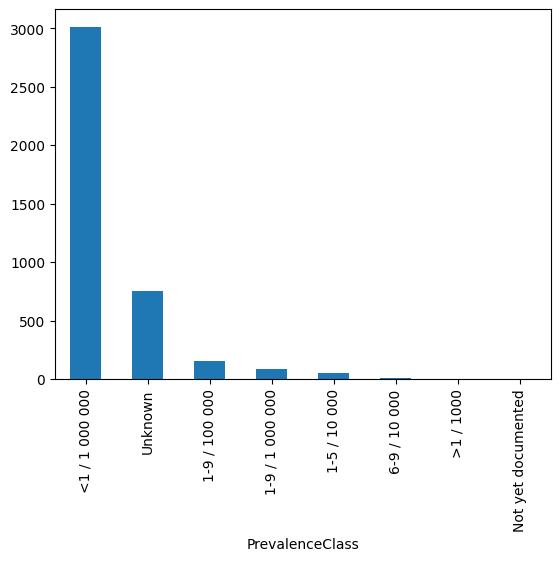

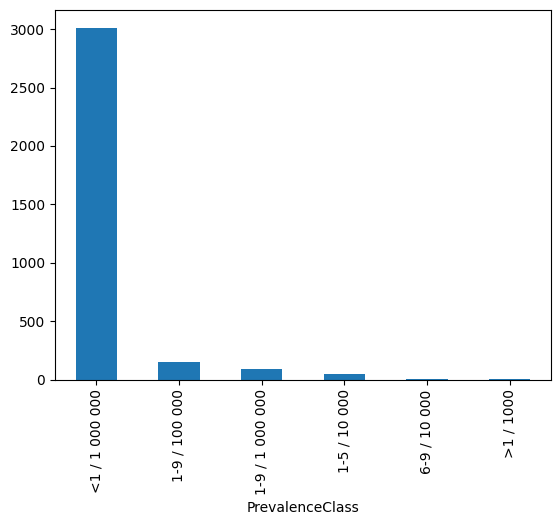

296


In [8]:
# how many rows do I have with PrevalenceGeographic Worldwide, PrevalenceValidationStatus Validated and a PrevalenceClass?
filtered = df[(df['PrevalenceGeographic'] == 'Worldwide') & (df['PrevalenceValidationStatus'] == 'Validated') & (df['PrevalenceClass'].notnull())]
filtered['PrevalenceClass'].value_counts().plot(kind='bar')
plt.show()

# remove Unknown and Not yet documented from the plot
filtered = df[(df['PrevalenceGeographic'] == 'Worldwide') & (df['PrevalenceValidationStatus'] == 'Validated') & (df['PrevalenceClass'].notnull()) & (df['PrevalenceClass'] != 'Unknown') & (df['PrevalenceClass'] != 'Not yet documented')]
filtered['PrevalenceClass'].value_counts().plot(kind='bar')
plt.show()

# print the total number of rows that are not '<1 / 1 000 000'
print(filtered[filtered['PrevalenceClass'] != '<1 / 1 000 000'].shape[0])


In [9]:
# lets plot the degree distribition of the prevalence classes
import networkx as nx
# read in this triple list ../Monarch_KG/monarch-kg_triples.2023-12-16.tsv
triples = pd.read_csv('../Monarch_KG/monarch-kg_triples.2023-12-16.tsv', sep='\t',header=None)
triples.columns = ['subject', 'predicate', 'object']
# create a non-directed graph from the triples
G = nx.from_pandas_edgelist(triples, 'subject', 'object', create_using=nx.Graph())

# map orphnet to mondo using mondo.json
import json

mondo = json.load(open('../Resources/mondo.json', 'r'))

orpha2mondo = {}

for node in mondo['graphs'][0]['nodes']:
    if 'meta' in node:
        if 'xrefs' in node['meta']:
            for x in node['meta']['xrefs']:
                if 'Orphanet' in x['val']:
                    # print(node['id'], x['val'])
                    orpha2mondo[x['val'].replace('Orphanet:','ORPHA:')] = node['id'].replace('http://purl.obolibrary.org/obo/MONDO_', 'MONDO:')

print(len(orpha2mondo))

# create a df of orphadiseases and their degree
deg_data = []
mondo_mappings = []
for node in filtered['ORPHAcode']:
    if node in orpha2mondo:
        deg_data.append(G.degree(orpha2mondo[node]))
        mondo_mappings.append(orpha2mondo[node])
    else:
        deg_data.append(None)
        mondo_mappings.append(None)

filtered['degree'] = deg_data
filtered['mondo'] = mondo_mappings
filtered.head()



10094


/tmp/ipykernel_128909/2629798692.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['degree'] = deg_data
/tmp/ipykernel_128909/2629798692.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['mondo'] = mondo_mappings


,ORPHAcode,Name,DisorderType,DisorderGroup,PrevalenceType,PrevalenceClass,PrevalenceGeographic,PrevalenceValidationStatus,degree,mondo
1,ORPHA:166024,"Multiple epiphyseal dysplasia, Al-Gazali type",Disease,Disorder,Point prevalence,<1 / 1 000 000,Worldwide,Validated,40,MONDO:0011778
5,ORPHA:166032,"Multiple epiphyseal dysplasia, with miniepiphyses",Disease,Disorder,Point prevalence,<1 / 1 000 000,Worldwide,Validated,12,MONDO:0012254
14,ORPHA:166029,"Multiple epiphyseal dysplasia, with severe pro...",Disease,Disorder,Point prevalence,<1 / 1 000 000,Worldwide,Validated,16,MONDO:0012253
16,ORPHA:166038,"Metaphyseal chondrodysplasia, Kaitila type",Disease,Disorder,Point prevalence,<1 / 1 000 000,Worldwide,Validated,2,MONDO:0009594
22,ORPHA:166035,Brachydactyly-short stature-retinitis pigmento...,Malformation syndrome,Disorder,Point prevalence,<1 / 1 000 000,Worldwide,Validated,62,MONDO:0009598


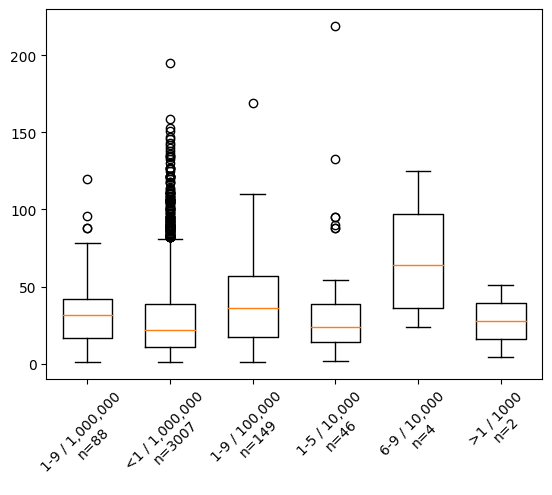

['<1 / 1 000 000' '1-9 / 100 000' '1-9 / 1 000 000' '1-5 / 10 000'
 '6-9 / 10 000' '>1 / 1000']


In [10]:
# box plots of the degree distribution grouped by PrevalenceClass
# keep only rows where the degree is an int
filtered = filtered[filtered['degree'].notnull()]
filtered['keep'] = [type(x) == int for x in filtered['degree']]
filtered = filtered[filtered['keep']]

fix, ax = plt.subplots()
xs = []
prevclasses = ['1-9 / 1 000 000', '<1 / 1 000 000', '1-9 / 100 000', '1-5 / 10 000', '6-9 / 10 000', '>1 / 1000'] # my manual sorting job
counts = []
for i,x in enumerate(prevclasses):
    sub = filtered[filtered['PrevalenceClass'] == x]
    ax.boxplot(sub['degree'], positions=[i], widths=0.6)
    counts.append(sub.shape[0])
ax.set_xticklabels([f'1-9 / 1,000,000\nn={counts[0]}', 
                    f'<1 / 1,000,000\nn={counts[1]}', 
                    f'1-9 / 100,000\nn={counts[2]}', 
                    f'1-5 / 10,000\nn={counts[3]}', 
                    f'6-9 / 10,000\nn={counts[4]}', 
                    f'>1 / 1000\nn={counts[5]}'],
                    rotation=45)
plt.show()

print(filtered['PrevalenceClass'].unique())

df.to_csv('../OrphanetEpidemiology/orphanet_epidemiology.filtered.mondo.degree.tsv', index=False, sep='\t')


Scoring 3,000+ diseases is not useful. I need someway to filter that group down more. I could use the 1-9 per million people, that group has 88, but is it fair to choose those to represent them all? Probably not.

Can I choose 300 diseases at random that are in the < 1 in a million>?

In [15]:
# save to a file the non 1 in a million diseases

non_ultra_rare = filtered[filtered['PrevalenceClass'] != '<1 / 1 000 000']
print(non_ultra_rare.shape)
print(non_ultra_rare.head())
non_ultra_rare[['ORPHAcode','Name','mondo','DisorderType','PrevalenceClass']].to_csv('../OrphanetEpidemiology/orphanet_epidemiology.non_ultra_rare.mondo.degree.tsv', index=False, sep='\t')

non_ultra_rare[['mondo']].to_csv('../OrphanetEpidemiology/290_non_ultra_rare.mondo_ids.tsv', index=False, sep='\t', header=False)

(289, 11)
        ORPHAcode                           Name      DisorderType  \
32      ORPHA:141                Canavan disease           Disease   
38      ORPHA:213                     Cystinosis           Disease   
51   ORPHA:166081  Von Willebrand disease type 2  Clinical subtype   
76   ORPHA:166096  Von Willebrand disease type 3  Clinical subtype   
109  ORPHA:166119       Isolated osteopoikilosis           Disease   

           DisorderGroup       PrevalenceType  PrevalenceClass  \
32              Disorder  Prevalence at birth    1-9 / 100 000   
38              Disorder  Prevalence at birth  1-9 / 1 000 000   
51   Subtype of disorder     Point prevalence  1-9 / 1 000 000   
76   Subtype of disorder     Point prevalence  1-9 / 1 000 000   
109             Disorder     Point prevalence    1-9 / 100 000   

    PrevalenceGeographic PrevalenceValidationStatus degree          mondo  \
32             Worldwide                  Validated     39  MONDO:0010079   
38             Wor

(3007, 11)


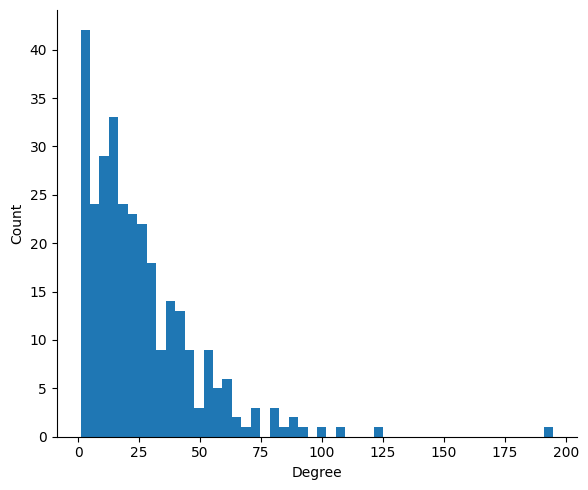

       ORPHAcode                              Name           DisorderType  \
6632  ORPHA:3455  Wiedemann-Rautenstrauch syndrome  Malformation syndrome   

     DisorderGroup    PrevalenceType PrevalenceClass PrevalenceGeographic  \
6632      Disorder  Point prevalence  <1 / 1 000 000            Worldwide   

     PrevalenceValidationStatus degree          mondo  keep  
6632                  Validated    195  MONDO:0009910  True  


In [13]:
# choose 300 diseases from the '<1 / 1 000 000' at random using a set seed
import numpy as np
np.random.seed(42)

sub = filtered[filtered['PrevalenceClass'] == '<1 / 1 000 000']
print(sub.shape)
sub = sub.sample(n=300)

sub[['ORPHAcode','Name','mondo','DisorderType','PrevalenceClass']].to_csv('../OrphanetEpidemiology/orphanet_epidemiology.ultra_rare.mondo.degree.tsv', index=False, sep='\t')

# write just mondo IDs of those 300 to a txt files
with open('../OrphanetEpidemiology/300_mondo_ids.txt', 'w') as f:
    for x in sub['mondo']:
        f.write(x + '\n')

# plot degree distribution of the 300
fig, ax = plt.subplots()
# set fig size
fig.set_size_inches(6, 5)
ax.hist(sub['degree'], bins=50)
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# use tight_layout
plt.tight_layout()
plt.savefig('../OrphanetEpidemiology/300_degree_distribution.png', dpi=300)
plt.show()

# which the is one with the highest degree?
print(sub[sub['degree'] == sub['degree'].max()])
